In [1]:
import random
import math
import json
import time
import numpy as np
from abc import ABC, abstractmethod
from scipy.spatial import distance_matrix

import matplotlib.pyplot as plt #for plotting

You are a logistics manager for a dilivery company 
tasked with optimizing the routing of a fleet of vehicles
to efficiently deliver goods to various customer locations.
Your goal is to optimize the delivery cost while ensuring that all
the delivery locations are visited, and all demands are met.


Assuming there is a sample program (refer sample solution attachment in appendix)in python solving the problem using genetic algorithms.

However, the program does not perform well by giving the optimum solution and not able to produce any result
when the total capacity of the vehicle is less than the total demand.


# Objective 1:
### You need to make modification to the code to find out the best route with the lowest cost required. (Hint: less than RM 120).

## Hard Contraints:
### - Each delivery location must be visited exactly once.
### - The total demand of each vehicle route must not exceed its maximum capacity.

## Soft Constraint:
### - Minimize cost required to meet all demands.

## Assumptions:
### - The vehicles start and end their routes at the same depot location.
### - Each vehicle only travels one round trip. (depart from depot and back to the depot)
### - There is not limit on the number of vehicles.
### - Travel times between any two locations are the same in both directions.
### - Deliveries can be made at any time, there are no time windows for deliveries.
### - Vehicle taravel distance is calculated using Euclidean distance formula:
### - Distance in km = 100 * √((Longitude2 - Longtitude1)^2 + (Latitude2 - Latitude1)^2)

In [2]:
class GeneticAlgorithm(ABC):
    """
    A class for solving problems using Genetic Algorithm

    Attributes
    --------
    pop_size: int
        Size of Population
    selection_size: int
        Size of selected population for further process
    num_gens: int
        Number of generations for evolution
    mutation_rate: float
        Probability for a mutation to occur
    elite_size: int
        Size of the number of elites for crossover
    crossover_rate: float
        Probability that crossover happens
    num_pts: int
        Number of points in a sequence (an individual)
    population: list[tuple]
        A list of current population where each of the individual contains its fitness score
    """
    def __init__(self, pop_size, selection_size, num_gens, mutation_rate,
                 elite_size, crossover_rate, 
                 num_pts):
        assert pop_size > elite_size
        self.pop_size = pop_size
        self.selection_size = selection_size
        self.num_gens = num_gens
        self.mutation_rate = mutation_rate
        self.elite_size = elite_size
        self.crossover_rate = crossover_rate
        self.num_pts= num_pts
        self.population = []

    @abstractmethod
    def crossover(self, parent1, parent2):
        """Perform cross over to produce offsprings.
        
        Parameters
        ------
        parent1: any
        parent2: any
        """
        pass

    @abstractmethod
    def mutate(self, individual):
        """Mutate an individual.
        
        Parameters
        ------
        individual: any
            The individual in a population
        """
        pass

    @abstractmethod
    def init_population(self):
        """Initialise the population.
        """
        pass
    
    @abstractmethod
    def calc_fitness(self, individual):
        """Abstract method to calculate fitness score of an individual
        
        Parameters
        ------
        individual: any
            The individual in a population
        """
        pass
    
    def rank_population(self,):
        """Calculate the fitness score of each individual, and sort the population in descending order
        
        Return
        ------
        Sorted population in list[tuple]
        """
        fit_results = [(individual, self.calc_fitness(individual)) for individual, _ in self.population]
        return sorted(fit_results, key=lambda x: x[1], reverse=True)
    
    def next_generation(self):
        """Evolves the existing generation and update the population.
        This functions first rank the individuals in the population, then performs
        crossover and mutation according to the probability set in prior.
        """
        
        ranked_population = self.rank_population()
        selected_population = ranked_population[:self.elite_size].copy()
        
        for _ in range(int((self.pop_size - self.elite_size) / 2)):
            
            if random.random() < self.crossover_rate:
                parent1 = sorted(
                    random.choices(ranked_population, k=self.selection_size),
                    key=lambda x: x[1], reverse=True
                )[0][0]
                parent2 = sorted(
                    random.choices(ranked_population, k=self.selection_size),
                    key=lambda x: x[1], reverse=True
                )[0][0]
                
                child1, child2 = self.crossover(parent1, parent2)
                
            else:#no crossover
                child1 = random.choices(selected_population)[0][0]
                child2 = random.choices(selected_population)[0][0]
                
            if random.random() < self.mutation_rate:
                
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
            
            selected_population.append((child1,self.calc_fitness(child1)))
            selected_population.append((child2,self.calc_fitness(child2)))
            
        self.population = selected_population
    
    def get_sol(self):
        """Return the individual that has the highest fitness score (serves as the current selected solution).

        Returns
        ----
        individual: any
            the individual that has the highest fitness score
        fitness: float
            fitness score of the individual
        """
        solution = self.rank_population()[0]
        individual = solution[0]
        fitness = solution[1]
        return individual, fitness

    def solve(self, early_stop: bool = True):
        """Entry point of the algorithm. Performs initialisation and generation evolution.

        Parameters
        --------
        early_stop: bool
            If set to true, algorithm ends if the last three generation has the highly similar best individuals (i.e. difference of the average with the existing is < 1e-4)
        """
        if len(self.population) == 0:
            self.init_population()
        solution_lists = []
        for i in range(self.num_gens):
            self.next_generation()
            if i%10 == 0:
                solution_lists.append(self.get_sol())
            #early stopping
#             if early_stop and len(solution_lists) >= 3 and abs(solution_lists[-1][1] - np.mean([fitness for _, fitness in solution_lists[-3:]])) < 1e-6:
#                 print("Early termination. Reason: converged. ")
#                 break
            if early_stop and len(solution_lists) >= 3:
                fitness_values = [fitness for _, fitness in solution_lists[-3:]]
                if np.all(np.abs(fitness_values[-1] - np.mean(fitness_values)) < 1e-6):
                    print("Early termination. Reason: converged.")
                    break
            if len(solution_lists) > 10:
                solution_lists = solution_lists[-3:]

In [3]:
class MVPGeneticAlgorithm(GeneticAlgorithm):
    """
    A class for solving multiple vehicle problem using Genetic Algorithm

    Attributes
    --------
    car_types: list[dict]
        types of car that has different capacity and cost
    cars: list[dict]
        list of cars that carry the information of the id and the car_type
    custs: list[dict]
        list of customers that carry the information of id, current location (pt) and demand.
    dist_matrix: np.array
        
    pop_size: int
        Size of Population
    selection_size: int
        Size of selected population for further process
    num_gens: int
        Number of generations for evolution
    mutation_rate: float
        Probability for a mutation to occur
    elite_size: int
        Size of the number of elites for crossover
    crossover_rate: float
        Probability that crossover happens
    num_pts: int
        Number of points in a sequence (an individual)
    population: list[tuple]
        A list of current population where each of the individual contains its fitness score
    """
    def __init__(self, car_types, cars, custs, depot, *kwargs):
        self.car_types = car_types
        self.cars = cars
        self.custs = custs
        self.dist_matrix = self._generate_dist_matrix(depot, custs, len(cars))
        super().__init__(*kwargs)

    def _generate_dist_matrix(self, depot, custs, num_cars):
        """Internal function for generating distance matrix.
        The 2-D matrix is first generated according to the distance of all customers, assuming only one car is used (so it is treated as TSP first).
        Then, the matrix is expanding both horizontally and vertically, i.e., add num_cars of rows and cols which each row/column represents the distance for a car to travel from depot to a specific customer (and vice versa).
        An example individual is D - C1 - C2 - D - C3 - C4 - D. (Given 5 customers, 2 cars)
        In a numerical representation, it will be [0, 1, 2, 5, 3, 5, 6], where 5 and 6 represents the 1st and 2nd car respectively.
        This distance matrix serves as a lookup table, e.g. get the distance between 1 and 2 from [0, 1].

        Parameters
        --------
        depot: tuple
            original point of the cars
        custs: list[dict]
            list of customers that carry the information of id, current location (pt) and demand.
        num_cars: int
            number of cars
        """
        points = [cust['pt'] for cust in custs]
        dist_car = [math.dist(depot, point) * 100 for point in points]
        dist_matrix = distance_matrix(points, points) * 100
        
        # Expand the matrix
        out_arr = np.tile(np.array(dist_car)[:, np.newaxis], (1, num_cars))
        up_arr =np.hstack((dist_matrix,out_arr))
        low_arr=np.array([dist_car + [0] * num_cars]* num_cars)
        dist_matrix = np.vstack((up_arr, low_arr))
        return dist_matrix
    
    def init_population(self):
        """Initialise the population according to the preset population size.
        Each individual must start with "0" (indicating the depot point), and end with the last car id (which should be equal to number of points)
        This ensures that all the individual is a valid combination, starting from the first point to the point where the id is a car id, all the points belong to this car.
        Hence, the last point must be a car, and from second to the second last point can be either representing a car or a customer.
        
        """
        self.population = []
        for _ in range(self.pop_size):
            individual = np.hstack((np.array([0]),np.random.permutation([i for i in range(1, self.num_pts)]), np.array([self.num_pts])))
            self.population.append((individual, None))
        self.population = self.rank_population()
        
    def mutate(self, individual):
        """Mutate an individual.
        
        Parameters
        ------
        individual: np.array
            The individual in a population, it should be a sequence of customer/ car id.
        """
        for first_id in range(1, len(individual) - 1): #ensure not to mutate the first and last point to maintain validity
            if random.random() < 0.2: 
                sec_id = random.randint(1, len(individual) - 2)
                individual[first_id], individual[sec_id] = individual[sec_id], individual[first_id]
        return individual
    
    def crossover(self, parent1, parent2):
        """Crossover two parents to produce 2 children using order crossover.
        We follow typical textbook approach, but we do not crossover the first and the last id to maintain validity.

        Parameters
        ------
        parent1: np.array
            First parent.
        parent2: np.array
            Second parent.
        """
        # Step 0: Preserve the last id value, first id is 0 so no need to save.
        parent1_last_id = parent1[-1]
        parent2_last_id = parent2[-1]
        parent1 = parent1[1:-1].copy()
        parent2 = parent2[1:-1].copy()
        changable_node_nums = self.num_pts - 1
        #Step 1: Select 2 points randomly
        c1 = int(random.random() * changable_node_nums) + 1
        c2 = int(random.random() * changable_node_nums) + 1
        if c2 < c1:
            c1, c2 = c2, c1
        #Step 2: Swap position to form part of child 1 and child 2.
        C1 = [None for _ in parent2]
        C2 = [None for _ in parent1]
        C1[c1 - 1: c2] = parent2[c1 - 1: c2]
        C2[c1 - 1: c2] = parent1[c1 - 1: c2]

        #Step 3: Create lsit L1 and L2.
        L1 = np.hstack((parent1[c2:], parent1[:c2]))
        L2 = np.hstack((parent2[c2:], parent2[:c2]))
        L1_p = [i for i in L1 if i not in C1]
        L2_p = [i for i in L2 if i not in C2]
        
        # Step 4: Assign L1' and L2' to C1, C2.
        for i, j in enumerate(L1_p):
            C1[(c2+i)%len(C1)] = j 
        for i, j in enumerate(L2_p):
            C2[(c2+i)%len(C2)] = j 

        # Step 5: Recover the first and last id.
        C1 = np.hstack(([0], C1, [parent1_last_id]))
        C2 = np.hstack(([0], C2, [parent2_last_id]))
        return C1, C2
    
    def calc_fitness(self, individual, show_log=False, verbose=False):
        """Calculate the fitness score of an individual.
        The fitness score is 100 divided by the total cost of travel (of all the cars). i.e., the lower the cost the higher the score.

        Parameters
        ------
        individual: np.array
            An individual which is a sequence of id.
        show_log: bool
            If true, details of the individual will be printed.
        """
        invalid = False
        total_cost, total_distance = 0, 0
        assigned_cars = [-1 for _ in range(len(individual))] # 1 index
        cur_car_id = -1
        individual_cars = [{"cost": 0, "distance": 0, "demand": 0} for _ in self.cars]
        
        for i_r, j in enumerate(reversed(individual)):
            i = len(individual) - i_r - 1
            if j == 0: # Nothing to do with the first point
                continue
            if j > len(self.custs): # For car points
                cur_car_id = j
                weight = self.car_types[self.cars[cur_car_id - 1- len(self.custs)]['type']]['cost']
                distance = self.dist_matrix[individual[i-1] - 1, individual[i] - 1]
                assigned_cars[i] = cur_car_id
                total_cost += weight * distance
                total_distance += distance
                individual_cars [cur_car_id -1 - len(self.custs)]['distance'] += distance
                individual_cars [cur_car_id -1 - len(self.custs)]['cost'] += weight * distance
            else: # For customer points
                assert cur_car_id != -1
                weight = self.car_types[self.cars[cur_car_id -1- len(self.custs)]['type']]['cost']
                distance = self.dist_matrix[individual[i-1] - 1, individual[i] - 1]
                assigned_cars[i] = cur_car_id
                total_cost += weight * distance
                total_distance += distance
                individual_cars [cur_car_id -1 - len(self.custs)]['demand'] += self.custs[j -1]['demand']
                individual_cars [cur_car_id -1 - len(self.custs)]['distance'] += distance
                individual_cars [cur_car_id -1 - len(self.custs)]['cost'] += weight * distance
                if  individual_cars [cur_car_id -1 - len(self.custs)]['demand'] > self.car_types[self.cars[cur_car_id -1- len(self.custs)]['type']]['capacity']:
                    invalid = True # total demands of all the customers in this car exceed the maximum capacity, the individual is invalid hence fitness score is zero.
                    break
                
        if not invalid:
            fitness = 100/ total_cost
            if show_log or verbose:
              print("Total distance = {0:.3f} km".format(total_distance))
              print("Total cost = RM {0:.2f}".format(total_cost))
              print()
              car_cnt = 0
              for i, j in enumerate(self.cars):
                if individual_cars[i]['distance'] == 0:
                    continue
                car_cnt+= 1
                print("Vehicle {0} (Type {1})".format(car_cnt, chr(j['type']+ord('A')))) #beautified counter
                print("Round Trip Distance: {0:.3f} km, Cost: RM {1:.2f}, Demand: {2}".format(individual_cars[i]['distance'],individual_cars[i]['cost'],individual_cars[i]['demand']))
                print("Depot -> ", end='')
                for ii, jj in enumerate(individual):
                    if assigned_cars[ii] != j['id']:
                        continue #ignore those not belong to me
                    elif assigned_cars[ii] == jj:
                        print("Depot ({0:.3f} km)".format(self.dist_matrix[individual[ii-1] - 1, individual[ii] - 1]))
                        break
                    print("C{0} ({1:.3f}km) -> ".format(jj, self.dist_matrix[individual[ii-1] - 1, individual[ii] - 1]), end='')
                print()
        else:
            if show_log or verbose:
                print("Infeasible.")
            fitness = 0
        return fitness, total_distance, total_cost #added return total distance and cost
#         return fitness

In [4]:
def gen_test_case(cust_size=30, rand_seed=42):
    """Generate test case.
    
    Parameters
    ---------
    cust_size: int
        Number of customers
    rand_seed: int
        random seed for random generation

    Returns
    ------
    car_types: list[dict]
        types of car
    depot: tuple
        starting point
    custs: list[dict]
        list of customers
    """
    car_types = [{"id": 0, "capacity": 25, "cost": 1.2},
                 {"id": 1, "capacity": 30, "cost": 1.5}]
    depot = (4.4184, 114.0932)
    custs = []
    random.seed(rand_seed)
    for i in range(cust_size):
          custs.append({"id": 11+i, "pt": (4.3032+random.random(), 113.8322+random.random()), "demand": random.randint(5,14) })

    return car_types, depot, custs


In [5]:
def save_test_case(out_dir, car_types, depot, custs):
    """Save test case to file in JSON.
    
    Parameters
    ---------
    out_dir: str
        file path of the JSON
    car_types: list[dict]
        types of car
    depot: tuple
        starting point
    custs: list[dict]
        list of customers
    """
    out_file = open(out_dir, "w")
    json.dump({"car_types": car_types,
                "depot": depot,
                "custs": custs
                },out_file,  indent = 4)
    out_file.close()



In [6]:
def load_problem(file_path='.'):
    """Load the problem.
    
    Parameters
    ---------
    file_path: str
        file path of the JSON

    Returns
    ------
    car_types: list[dict]
        types of car
    depot: tuple
        starting point
    custs: list[dict]
        list of customers
    """
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data['car_types'], data['depot'], data['custs']



In [7]:
for i in range(20, 60, 10):
    car_types, depot, custs = gen_test_case(i)
    save_test_case(f"MVP{i}.json",car_types, depot, custs)

    
all_results = {}
    
#To loop through all the test cases
for i in range(20, 60, 10):
    sample_test = {"path": f"sample_data.json", "best_ind": [], "best_score": 0.0, "avg_score": 0.0, "avg_time": 0.0}
    start_time = time.time()
    car_types, depot, custs = load_problem(sample_test['path'])
    num_cars = len(custs) * 2
    cars = [{"id": len(custs) + i + 1, "type": i // int(num_cars / 2)} for i in range(num_cars)]
    
    #a few trial and error with the parameters
    POP_SIZE = 100
    SELECTION_SIZE = 40
    ELITE_SIZE = 10
    NUM_GENS = 100
    MUTATION_RATE = 0.2
    CROSSOVER_RATE = 0.6
    NUM_PTS = num_cars + len(custs)

    ga = MVPGeneticAlgorithm(
        car_types, cars, custs, depot,
        POP_SIZE, SELECTION_SIZE, NUM_GENS,
        MUTATION_RATE, ELITE_SIZE, CROSSOVER_RATE, NUM_PTS,
    )

    print(f"Running Genetic Algorithm on test case MVP{i}.json :\n")
    ga.solve()

    
    population_results = []
    for j in range(len(ga.population)):
            print(f"Evaluating individual {j + 1}/{len(ga.population)}")
            fitness_score, total_distance, total_cost = ga.calc_fitness(ga.population[j][0], verbose=True)
            population_results.append((fitness_score, total_distance, total_cost))
    
    all_results[f"MVP{i}"] = population_results
            
            
    best_individual, best_score = ga.get_sol()
    end_time = time.time()
    
#     fitness_score, total_distance, total_cost = ga.calc_fitness(best_individual, show_log=True)
    
    best_score = float(best_score[0])
    if best_score > sample_test['best_score']:
        sample_test['best_score'] = best_score
        sample_test['best_ind'] = best_individual
    sample_test['avg_score'] += best_score
    sample_test['avg_time'] += end_time - start_time

    sample_test['avg_score'] /= 5
    sample_test['avg_time'] /= 5

    
        
    print(sample_test)


    # print("Final Result: ")
    print(f"Final Result for MVP{i}.json:")
    fitness_score, total_distance, total_cost = ga.calc_fitness(sample_test['best_ind'], show_log=True)


# for test_case, results in all_results.items():
#     fitness_scores, total_distances, total_costs = zip(*results)

#     plt.figure(figsize=(14, 7))

#     plt.subplot(1, 2, 1)
#     plt.plot(range(POP_SIZE), total_distances, marker='o')
#     plt.xlabel('Individual')
#     plt.ylabel('Total Distance (km)')
#     plt.title(f'Total Distance for {test_case}')

#     plt.subplot(1, 2, 2)
#     plt.plot(range(POP_SIZE), total_costs, marker='o')
#     plt.xlabel('Individual')
#     plt.ylabel('Total Cost (RM)')
#     plt.title(f'Total Cost for {test_case}')

#     plt.tight_layout()
#     plt.show()

Running Genetic Algorithm on test case MVP20.json :

Evaluating individual 1/100
Total distance = 97.729 km
Total cost = RM 117.27

Vehicle 1 (Type A)
Round Trip Distance: 40.557 km, Cost: RM 48.67, Demand: 22
Depot -> C7 (6.508km) -> C10 (6.018km) -> C9 (5.060km) -> C8 (11.358km) -> Depot (11.612 km)

Vehicle 2 (Type A)
Round Trip Distance: 35.842 km, Cost: RM 43.01, Demand: 14
Depot -> C1 (13.152km) -> C4 (4.021km) -> C3 (8.323km) -> Depot (10.347 km)

Vehicle 3 (Type A)
Round Trip Distance: 21.330 km, Cost: RM 25.60, Demand: 21
Depot -> C6 (8.061km) -> C5 (2.594km) -> C2 (1.604km) -> Depot (9.072 km)

Evaluating individual 2/100
Total distance = 97.729 km
Total cost = RM 117.27

Vehicle 1 (Type A)
Round Trip Distance: 40.557 km, Cost: RM 48.67, Demand: 22
Depot -> C7 (6.508km) -> C10 (6.018km) -> C9 (5.060km) -> C8 (11.358km) -> Depot (11.612 km)

Vehicle 2 (Type A)
Round Trip Distance: 35.842 km, Cost: RM 43.01, Demand: 14
Depot -> C1 (13.152km) -> C4 (4.021km) -> C3 (8.323km) -> D

Evaluating individual 1/100
Total distance = 105.149 km
Total cost = RM 126.18

Vehicle 1 (Type A)
Round Trip Distance: 26.396 km, Cost: RM 31.68, Demand: 19
Depot -> C2 (9.072km) -> C6 (1.834km) -> C7 (8.982km) -> Depot (6.508 km)

Vehicle 2 (Type A)
Round Trip Distance: 53.566 km, Cost: RM 64.28, Demand: 25
Depot -> C5 (10.483km) -> C1 (4.839km) -> C4 (4.021km) -> C3 (8.323km) -> C8 (14.290km) -> Depot (11.612 km)

Vehicle 3 (Type A)
Round Trip Distance: 25.187 km, Cost: RM 30.22, Demand: 13
Depot -> C9 (11.691km) -> C10 (5.060km) -> Depot (8.436 km)

Evaluating individual 2/100
Total distance = 105.149 km
Total cost = RM 126.18

Vehicle 1 (Type A)
Round Trip Distance: 26.396 km, Cost: RM 31.68, Demand: 19
Depot -> C2 (9.072km) -> C6 (1.834km) -> C7 (8.982km) -> Depot (6.508 km)

Vehicle 2 (Type A)
Round Trip Distance: 53.566 km, Cost: RM 64.28, Demand: 25
Depot -> C5 (10.483km) -> C1 (4.839km) -> C4 (4.021km) -> C3 (8.323km) -> C8 (14.290km) -> Depot (11.612 km)

Vehicle 3 (Type A)


Evaluating individual 1/100
Total distance = 103.380 km
Total cost = RM 124.06

Vehicle 1 (Type A)
Round Trip Distance: 53.582 km, Cost: RM 64.30, Demand: 25
Depot -> C7 (6.508km) -> C10 (6.018km) -> C9 (5.060km) -> C8 (11.358km) -> C3 (14.290km) -> Depot (10.347 km)

Vehicle 2 (Type A)
Round Trip Distance: 16.122 km, Cost: RM 19.35, Demand: 8
Depot -> C6 (8.061km) -> Depot (8.061 km)

Vehicle 3 (Type A)
Round Trip Distance: 33.677 km, Cost: RM 40.41, Demand: 24
Depot -> C2 (9.072km) -> C5 (1.604km) -> C1 (4.839km) -> C4 (4.021km) -> Depot (14.142 km)

Evaluating individual 2/100
Total distance = 103.380 km
Total cost = RM 124.06

Vehicle 1 (Type A)
Round Trip Distance: 53.582 km, Cost: RM 64.30, Demand: 25
Depot -> C7 (6.508km) -> C10 (6.018km) -> C9 (5.060km) -> C8 (11.358km) -> C3 (14.290km) -> Depot (10.347 km)

Vehicle 2 (Type A)
Round Trip Distance: 16.122 km, Cost: RM 19.35, Demand: 8
Depot -> C6 (8.061km) -> Depot (8.061 km)

Vehicle 3 (Type A)
Round Trip Distance: 33.677 km, C

Evaluating individual 1/100
Total distance = 104.459 km
Total cost = RM 125.35

Vehicle 1 (Type A)
Round Trip Distance: 30.246 km, Cost: RM 36.29, Demand: 11
Depot -> C3 (10.347km) -> C2 (10.827km) -> Depot (9.072 km)

Vehicle 2 (Type A)
Round Trip Distance: 40.557 km, Cost: RM 48.67, Demand: 22
Depot -> C7 (6.508km) -> C10 (6.018km) -> C9 (5.060km) -> C8 (11.358km) -> Depot (11.612 km)

Vehicle 3 (Type A)
Round Trip Distance: 33.656 km, Cost: RM 40.39, Demand: 24
Depot -> C4 (14.142km) -> C1 (4.021km) -> C5 (4.839km) -> C6 (2.594km) -> Depot (8.061 km)

Evaluating individual 2/100
Total distance = 112.942 km
Total cost = RM 135.53

Vehicle 1 (Type A)
Round Trip Distance: 42.820 km, Cost: RM 51.38, Demand: 14
Depot -> C7 (6.508km) -> C3 (16.413km) -> C2 (10.827km) -> Depot (9.072 km)

Vehicle 2 (Type A)
Round Trip Distance: 36.466 km, Cost: RM 43.76, Demand: 19
Depot -> C10 (8.436km) -> C9 (5.060km) -> C8 (11.358km) -> Depot (11.612 km)

Vehicle 3 (Type A)
Round Trip Distance: 33.656 k

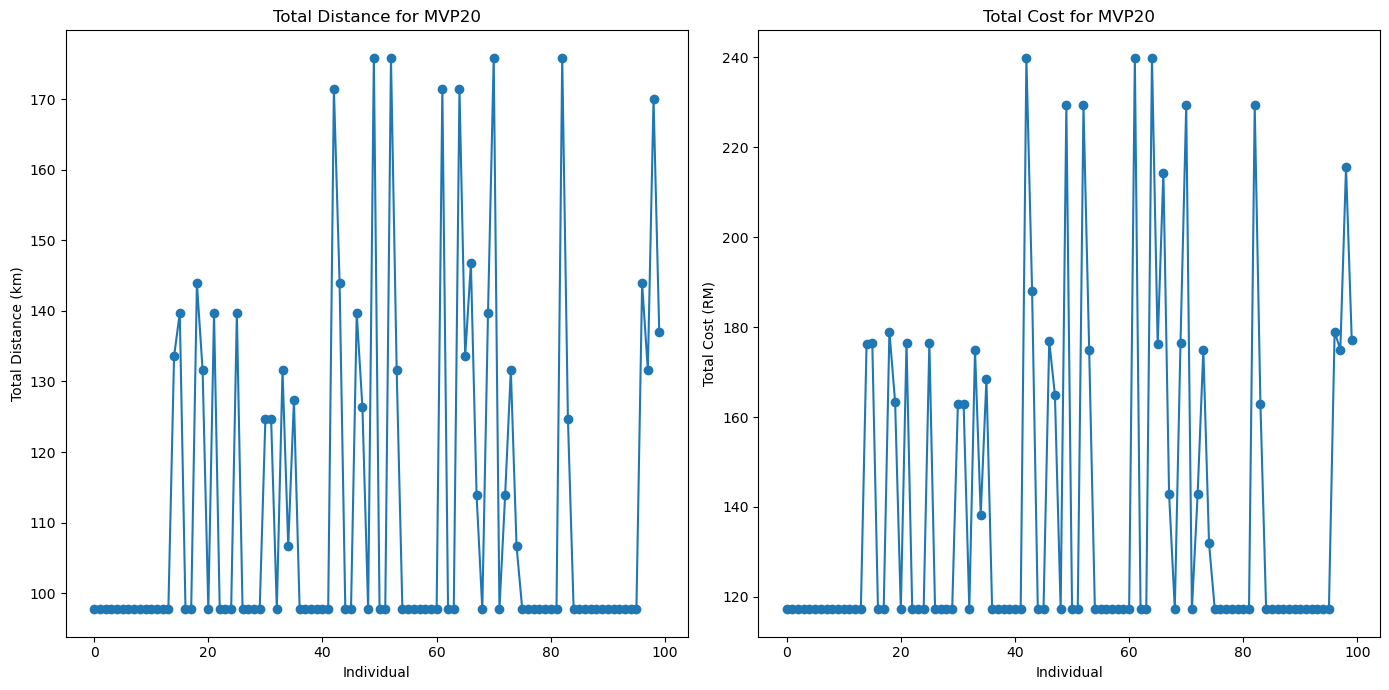

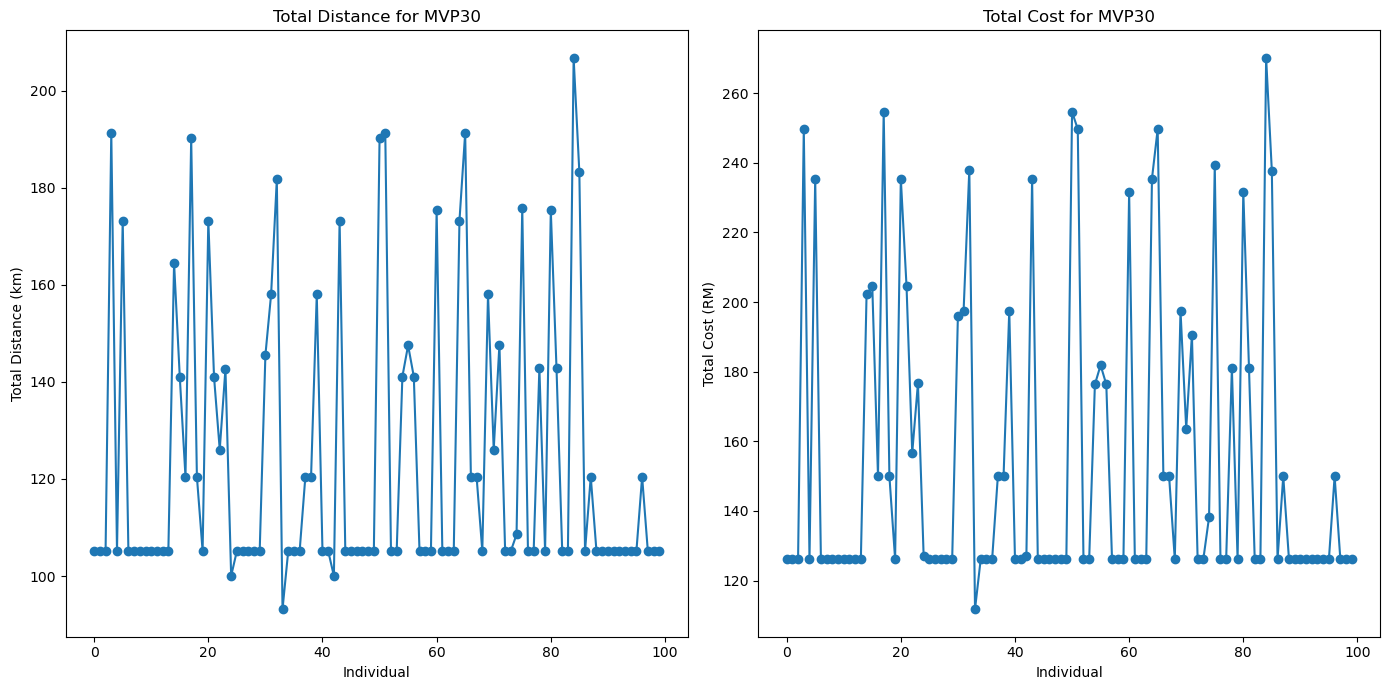

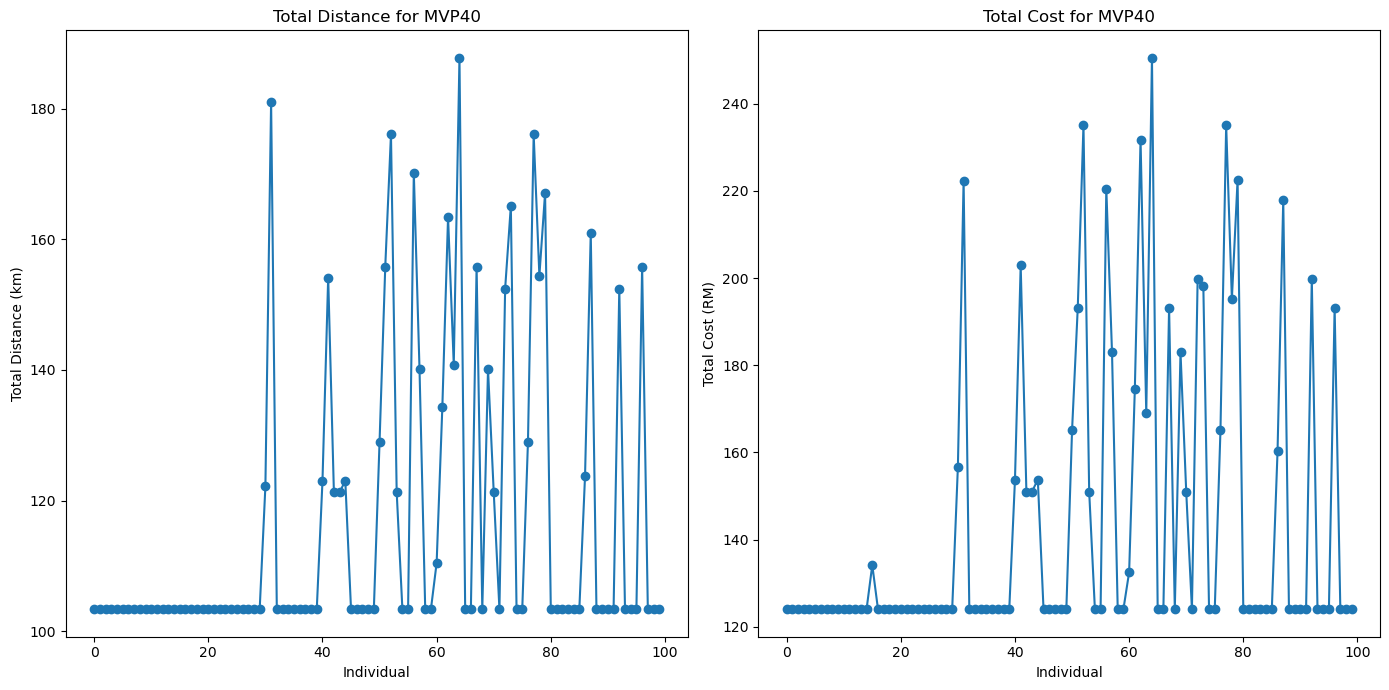

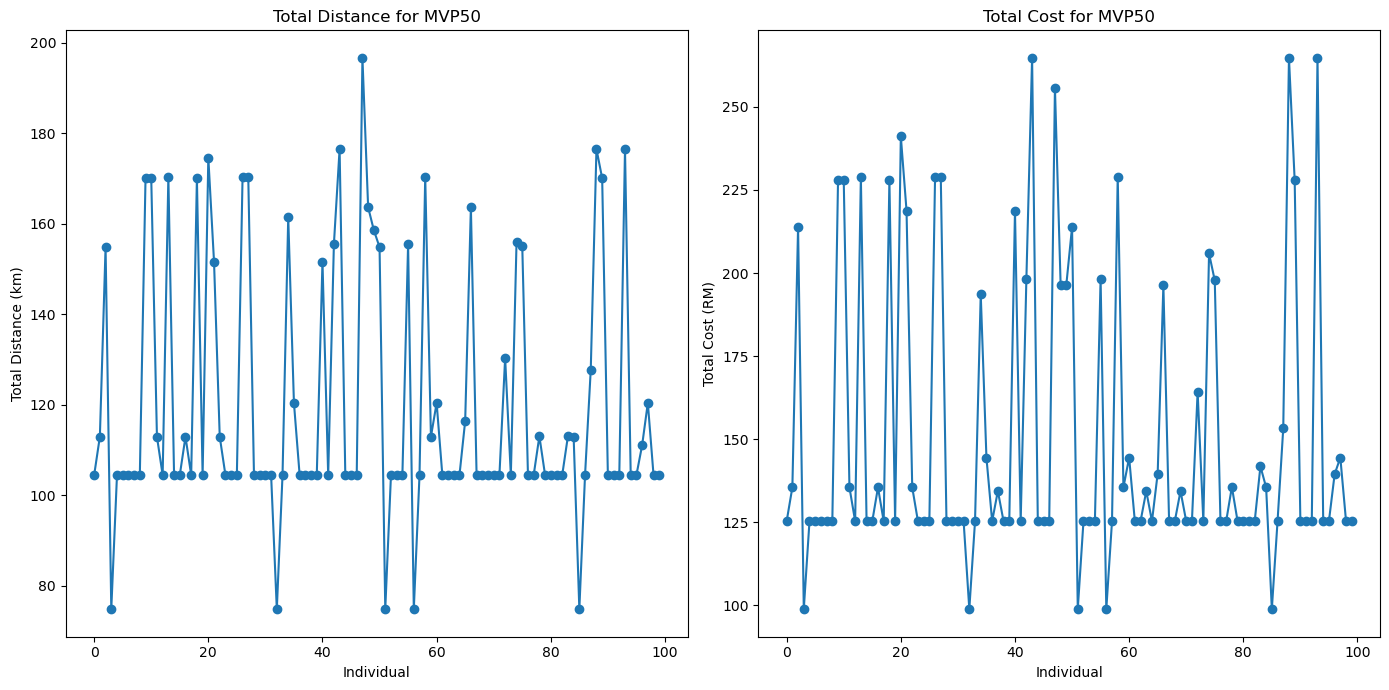

In [8]:
for test_case, results in all_results.items():
    fitness_scores, total_distances, total_costs = zip(*results)

    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.plot(range(POP_SIZE), total_distances, marker='o')
    plt.xlabel('Individual')
    plt.ylabel('Total Distance (km)')
    plt.title(f'Total Distance for {test_case}')

    plt.subplot(1, 2, 2)
    plt.plot(range(POP_SIZE), total_costs, marker='o')
    plt.xlabel('Individual')
    plt.ylabel('Total Cost (RM)')
    plt.title(f'Total Cost for {test_case}')

    plt.tight_layout()
    plt.show()

In [9]:
#     results.append((i, total_distance, total_cost))

# Plotting the results
# test_case_sizes, total_distances, total_costs = zip(*results)

# plt.figure(figsize=(14, 7))

# plt.subplot(1, 2, 1)
# plt.plot(test_case_sizes, total_distances, marker='o')
# plt.xlabel('Number of Customers')
# plt.ylabel('Total Distance (km)')
# plt.title('Total Distance for Different Test Cases')

# plt.subplot(1, 2, 2)
# plt.plot(test_case_sizes, total_costs, marker='o')
# plt.xlabel('Number of Customers')
# plt.ylabel('Total Cost (RM)')
# plt.title('Total Cost for Different Test Cases')

# plt.tight_layout()
# plt.show()
